In [1]:
%pylab inline
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

folder="../../../../../sebas/data/air_qual_aemet/"
stations = os.listdir(folder)
stations = pd.Series(stations).apply(lambda e: e.split(".csv")[0]).values

In [3]:
fields=['AEMET.BLH', 'AEMET.SP', 'AEMET.T2M', 'AEMET.TP', 'AEMET.U10',
       'AEMET.V10', 'AEMET.WS', 'AEMET.WD', 'MACC.NO2', 'MACC.O3', 'MACC.PM10',
       'MACC.PM25', 'SPA.NO2', 'SPA.O3', 'SPA.PM10', 'SPA.PM25']

fields=['MACC.NO2', 'MACC.O3', 'MACC.PM10',
       'MACC.PM25', 'SPA.NO2', 'SPA.O3', 'SPA.PM10', 'SPA.PM25']

#fields=['SPA.NO2', 'SPA.O3']

fields=['SPA.NO2']

In [4]:
from tqdm.notebook import tqdm

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
seq_length=168

In [7]:
stations=["28079004"]

  0%|          | 0/1 [00:00<?, ?it/s]

28079004: SPA.NO2


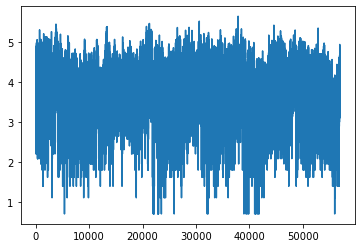

In [8]:
X_train=[]
y_train=[]
for station in tqdm(stations):
    # Reading input file
    df = pd.read_csv(f"{folder}/{station}.csv",sep=";")
    # Limiting Date
    df = df[df["DATE"]<"2020-01-01"]
    for field in fields:
        print(f"{station}: {field}")
        
        tdf = df[["DATE",field]].copy()

        #Stop is there are null values
        if (tdf[field].isnull().sum()>0):
          break

        # Log transform
        tdf[field]=np.log1p(tdf[field])

        plt.plot(tdf[field])
        plt.show()
        #STL Decomp
        #stl = seasonal_decompose(tdf[field], model="additive",period=24)

        #tdf[field]=tdf[field]-stl.seasonal
        #tdf["trend"]=stl.trend
        tdf["trend"]=0


        horizon=13

        tdf["trend_norm"]=tdf["trend"].shift(horizon)

        # We remove the trend and keep past values
        tdf[field]=tdf[field]-tdf["trend_norm"]
        for h in np.arange(0,horizon+seq_length+1):
            if h>horizon:
                temp = pd.DataFrame()
                temp[f"value - {h}"]=(tdf[field].shift(h)-tdf["trend_norm"]).copy()
                tdf=pd.concat([tdf,temp],axis=1)

        tdf=tdf.dropna()

        cols = tdf.columns[tdf.columns.str.contains(f"value -")]
        X = tdf[cols].copy()
        y = tdf[[field]].copy()
        y.columns=["values"]

        TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

        X_train.append(X[X.index<=TRAIN_SPLIT].copy())
        y_train.append(y[X.index<=TRAIN_SPLIT].copy())
        
X_train=pd.concat(X_train)
y_train=pd.concat(y_train)

In [9]:
X.shape

(56796, 168)

In [10]:
X_train.shape

(39277, 168)

In [11]:
station="28079004"
df = pd.read_csv(f"/home/sebas/data/air_qual_aemet/{station}.csv",sep=";")

# Limiting Date
df = df[df["DATE"]<"2020-01-01"]

field="SPA.NO2"

tdf = df[["DATE",field]].copy()
tdf[field]=np.log1p(tdf[field])

#from statsmodels.tsa.seasonal import seasonal_decompose
#stl = seasonal_decompose(tdf[field], model="additive",period=24)
#tdf[field]=tdf[field]-stl.seasonal
#tdf["trend"]=stl.trend
tdf["seasonal"]=0
tdf["trend"]=0

horizon=13

tdf["trend_norm"]=tdf["trend"].shift(horizon)

# We remove the trend and keep past values
for h in np.arange(0,horizon+seq_length+1):
    if h>horizon:
            temp = pd.DataFrame()
            temp[f"{field} - {h}"]=(tdf[field].shift(h)-tdf["trend_norm"]).copy()
            tdf=pd.concat([tdf,temp],axis=1)
tdf=tdf.dropna()

cols = tdf.columns[tdf.columns.str.contains(f"{field} -")]
X = tdf[cols].copy()
y = tdf[[field]].copy()
v_recover = tdf[["trend_norm","seasonal"]]

TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

X_test=X[X.index>TRAIN_SPLIT].copy()
y_test = y[X.index>TRAIN_SPLIT].copy()
v_recover_test = v_recover[X.index>TRAIN_SPLIT].copy()

In [12]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test= torch.FloatTensor(y_test.values)

In [13]:
# https://github.com/harryliew/COCOB-optimizer/blob/master/cocob_bp.py

import torch.optim as optim
import torch

###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8):
        
        self._alpha = alpha
        self.epsilon = epsilon
        defaults = dict(alpha=alpha, epsilon=epsilon)
        super(COCOBBackprop, self).__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
        
                grad = p.grad.data
                state = self.state[p]
                
                if len(state) == 0:
                    state['gradients_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['grad_norm_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['L'] = self.epsilon * torch.ones_like(p.data).cuda().float()
                    state['tilde_w'] = torch.zeros_like(p.data).cuda().float()
                    state['reward'] = torch.zeros_like(p.data).cuda().float()
                    
                gradients_sum = state['gradients_sum']
                grad_norm_sum = state['grad_norm_sum']
                tilde_w = state['tilde_w']
                L = state['L']
                reward = state['reward']
                
                zero = torch.cuda.FloatTensor([0.])
                
                L_update = torch.max(L, torch.abs(grad))
                gradients_sum_update = gradients_sum + grad
                grad_norm_sum_update = grad_norm_sum + torch.abs(grad)
                reward_update = torch.max(reward - grad * tilde_w, zero)
                new_w = -gradients_sum_update/(L_update * (torch.max(grad_norm_sum_update + L_update, self._alpha * L_update)))*(reward_update + L_update)
                p.data = p.data - tilde_w + new_w
                tilde_w_update = new_w
                
                state['gradients_sum'] = gradients_sum_update
                state['grad_norm_sum'] = grad_norm_sum_update
                state['L'] = L_update
                state['tilde_w'] = tilde_w_update
                state['reward'] = reward_update

        return loss


In [14]:
import pytorch_lightning as pl

class TCN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.n_channels = 128
        self.k_size = 3

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.n_channels, kernel_size=self.k_size, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )

        self.regressor = nn.Sequential(
            nn.LayerNorm(self.n_channels*int(seq_length/2)),
            nn.Linear(self.n_channels*int(seq_length/2),200),
            nn.ReLU(),
            nn.LayerNorm(200),
            nn.Linear(200,1)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,self.n_channels*x.shape[2])
        return self.regressor(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat  = self(x)
        criterion = nn.MSELoss(reduction='sum')
        loss = criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = COCOBBackprop(self.parameters())
        return optimizer


In [30]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

In [31]:
# setup data
X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train_loader = DataLoader(train, batch_size=32, shuffle=True,num_workers=8)

In [32]:
trainer = pl.Trainer(max_epochs=10,accelerator="gpu")
tcn=TCN()
trainer.fit(model=tcn, train_dataloaders=train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 512   
1 | regressor | Sequential | 2.2 M 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.693     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [38]:
trainer.checkpoint_callback.best_model_path

'/home/sebas/Documents/projects/exp_article3/notebooks/lightning_logs/version_27/checkpoints/epoch=9-step=12280.ckpt'

In [39]:
X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))

In [40]:
model = tcn.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
model.freeze()
model = model.eval()

In [41]:
from sklearn.metrics import mean_squared_error

 Val Loss: 0.5197588205337524


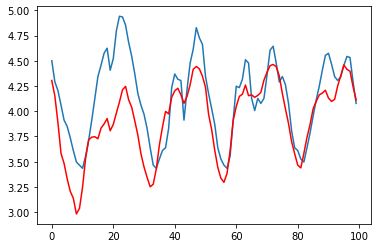

In [42]:
# automatically auto-loads the best weights from the previous run
predictions = model(X_test_gf).detach().numpy()
print(f' Val Loss: {np.sqrt(mean_squared_error(predictions,y_test.cpu()))}')
    
plt.plot(y_test.cpu()[-100:])
plt.plot(predictions[-100:],c="red")
plt.show()

### Parameters:
- Number of channels
- Kernel Size
- Maxpool size
- Batch Size
- Epochs
- Regressor:
    - Size
    - Number of hidden layers

In [19]:
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformIntegerHyperparameter
from smac.facade.smac_bb_facade import SMAC4BB
from smac.scenario.scenario import Scenario

In [ ]:
net = Net() 
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = COCOBBackprop(net.parameters())
#optimizer = optim.Adam(net.parameters(),lr=0.00001,weight_decay=0.000001)

loss_arr = []
val_loss_arr = []
epochs = 1

X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train_loader = DataLoader(train, batch_size=512, shuffle=True)

print(len(X_train)/512)

for j in range(epochs):
    m_loss = []
    for i,batch in tqdm(enumerate(train_loader)):
      train_features, train_labels = batch
      y_hat = net.forward(train_features)
      loss = criterion(y_hat, train_labels)
      m_loss.append(loss.cpu().detach().numpy())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss_arr.append(np.mean(m_loss))

    X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
    predictions = net(X_test_gf).cpu().reshape(-1).detach().numpy()
    val_loss_arr.append(np.sqrt(mean_squared_error(predictions,y_test.cpu())))
    print(f'Epoch: {j} Loss: {np.mean(m_loss)} Val Loss: {np.sqrt(mean_squared_error(predictions,y_test.cpu()))}')
    
    plt.plot(y_test.cpu()[-100:])
    plt.plot(predictions[-100:],c="red")
    plt.show()

In [ ]:


X_train, y_train = np.random.randint(2, size=(20, 2)), np.random.randint(2, size=20)
X_val, y_val = np.random.randint(2, size=(5, 2)), np.random.randint(2, size=5)


def train_random_forest(config):
    model = RandomForestClassifier(max_depth=config["depth"])
    model.fit(X_train, y_train)

    # Define the evaluation metric as return
    return 1 - model.score(X_val, y_val)


# Define your hyperparameters
configspace = ConfigurationSpace()
configspace.add_hyperparameter(UniformIntegerHyperparameter("depth", 2, 100))
configspace.add_hyperparameter(UniformIntegerHyperparameter("n_estimators", 2, 100))

# Provide meta data for the optimization
scenario = Scenario({
    "run_obj": "quality",  # Optimize quality (alternatively runtime)
    "runcount-limit": 10,  # Max number of function evaluations (the more the better)
    "cs": configspace,
})

smac = SMAC4BB(scenario=scenario, tae_runner=train_random_forest)
best_found_config = smac.optimize()